# Using the IO-Model-Builder
`iomb` is an open source Python library for creating and calculating 
environmentally extended input-output models (EEIO models) directly from CSV files.
This library was developed for the US EPA with support from CSRA and GreeDelta.
This notebook shows the functionalities of `iomb` with a simple example.

## Calculating a technical coefficients matrix
`iomb` contains functions to calculate the _technical coefficients matrix_ 
$\mathbf{A}$ from a _use table_ $\mathbf{U}$ and a _supply table_ $\mathbf{V}$ 
as described in the 
[Concepts and Methods of the U.S. Input-Output Accounts, Chapter 12](http://www.bea.gov/papers/pdf/IOmanual_092906.pdf). 
The supply and use tables that `iomb` can process are stored in CSV files with
sector keys as column and row headers and plain numeric values as cell entries.
The sector keys identify the rows and columns and are also used to link the
economic data to the data in the satellite and meta-data tables. 

The function `iomb.make_io_model` takes the file paths of the supply and use
tables as parameters and creates an input-output model. This function also
accepts a list of optional scrap sectors for scrap adjustments. The 
[supply](https://github.com/USEPA/IO-Model-Builder/blob/master/example/supply_table.csv) 
and [use table of the example](https://github.com/USEPA/IO-Model-Builder/blob/master/example/use_table.csv) 
can be combined in an IO model with the following function:  


In [1]:
from pylab import *

In [2]:
import iomb

io_model = iomb.make_io_model('supply_table.csv', 'use_table.csv', 
                              scrap_sectors=['s/scrap/us'])

The supply table (or make table) is an industry-commodity matrix and the use table a 
commodity-industry matrix with additional rows for added values and additional
columns for final demand sectors. `iomb` identifies row-keys of the use-table that are
not contained in the column-keys of the make table as value added sectors and,
in the same way, column-keys of the use-table that are not contained in the rows
of the make table as final demand sectors. The function `viz_use_table` which
can be called on with `iomb.io.Model` calculates a visualization of this sector
classification:

<IPython.core.display.Javascript object>


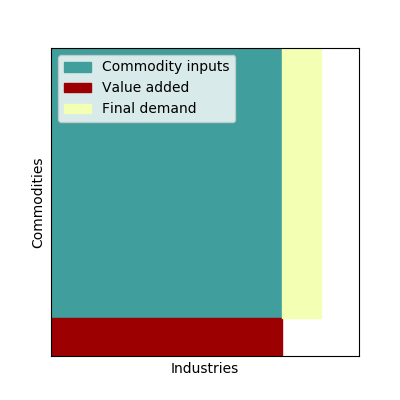

In [3]:
%matplotlib notebook
io_model.viz_use_table()

The row sums of the use table are the total commodity outputs of all industries
and should be equal to the column sums of the supply table. In the same way,
the column sums in the use table are the total industry outputs and should
be the same as the row sums in the supply table. The function `viz_totals` shows
these totals of both tables. If the input-output model is correctly balanced the
data points should be on a line for the commodity and industry totals:

<IPython.core.display.Javascript object>


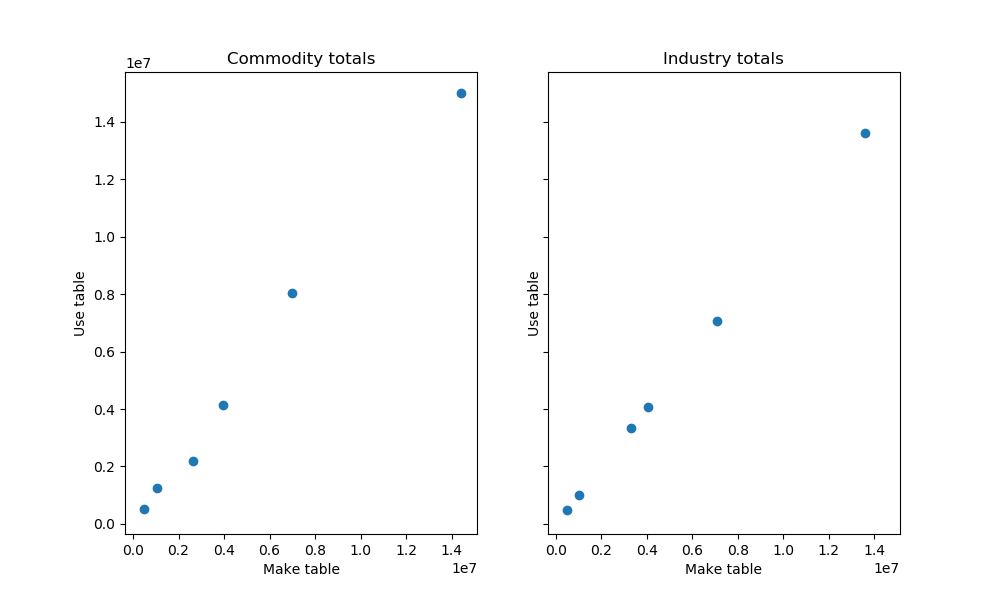

In [4]:
io_model.viz_totals()

The function `get_dr_coefficients` calculates the direct requirements
coefficients matrix $\mathbf{A}$. The intermediate calculation steps like the
calculation of the transformation matrix are also available via functions of 
the `iomb.io.Model` class (e.g. `get_transformation_matrix` etc.). For the
example we calculate the coefficients matrix and save it to a CSV file `drc.csv`:

In [3]:
drc = io_model.get_dr_coefficients()
drc.to_csv('drc.csv')
drc


,1/agriculture & forestry/us,2/mining & utilities/us,3/construction & manufacturing/us,4/trade & transport/us,5/information & finance & services/us,6/government & other/us
1/agriculture & forestry/us,0.204289,0.000202,0.037004,0.001439,0.001135,0.000556
2/mining & utilities/us,0.021635,0.130418,0.094129,0.011322,0.012768,0.015685
3/construction & manufacturing/us,0.210018,0.095349,0.323271,0.072071,0.064439,0.128240
4/trade & transport/us,0.092089,0.043200,0.078659,0.085746,0.023799,0.030353
5/information & finance & services/us,0.066902,0.106421,0.085925,0.202570,0.283272,0.174513
6/government & other/us,0.001980,0.003065,0.003178,0.006411,0.004732,0.009160


iomb` uses the [pandas DataFrame class](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html)
wherever possible. With this, the standard pandas API can be used to further
work with the result data. For example, to analyze the direct requirements of
the `3/construction & manufacturing/us` sector, we can do:

<IPython.core.display.Javascript object>


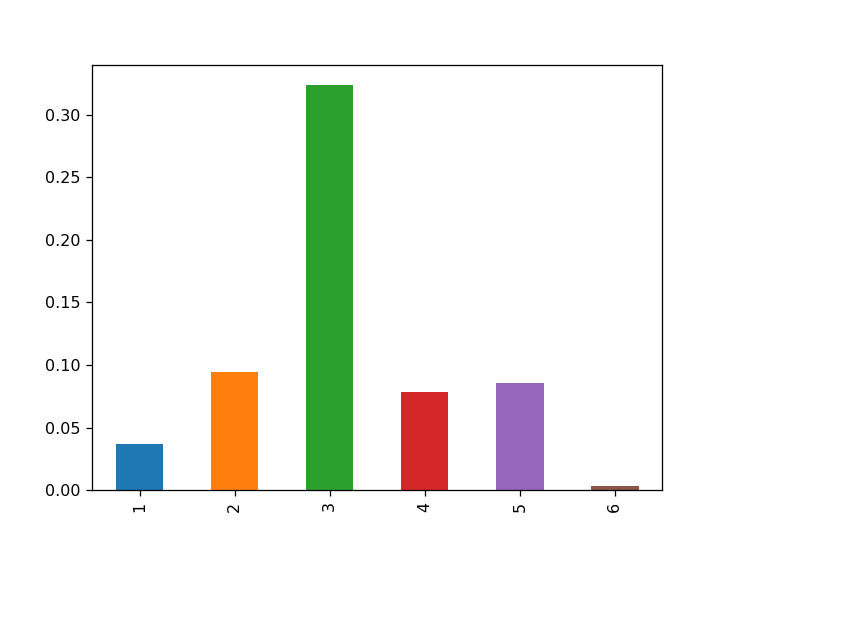

In [4]:
%matplotlib notebook
inputs = drc.loc[:,'3/construction & manufacturing/us'].copy()
inputs.index = [label[0] for label in inputs.index]
inputs.plot.bar()

## Satellite tables
In `iomb` satellite tables are read from a CSV file with elementary flow inputs
or outputs per 1 unit of sector output. To convert a industry based satellite 
matrix to a commodity based matrix that can be used with a commodity by commodity
coefficients matrix, `iomb` provides a function `apply_market_shares` which can
be called on an instance of the `iomb.sat.Table` class. Assuming that the
[satellite table of the example](https://github.com/USEPA/IO-Model-Builder/blob/master/example/supply_table.csv)
is industry based, we convert it to a commodity-based table and save it to the
file `satellite_table_com.csv`:

In [5]:
sat_i = iomb.make_sat_table('satellite_table.csv')
sat_c = sat_i.apply_market_shares(io_model.get_market_shares(), 'sector_meta_data.csv')
sat_c.to_csv('satellite_table_com.csv')

A satellite table can be also converted into a pandas DataFrame. For example,
the CO2 emissions per 1 USD output of our example sectors can be visualized via:

<IPython.core.display.Javascript object>


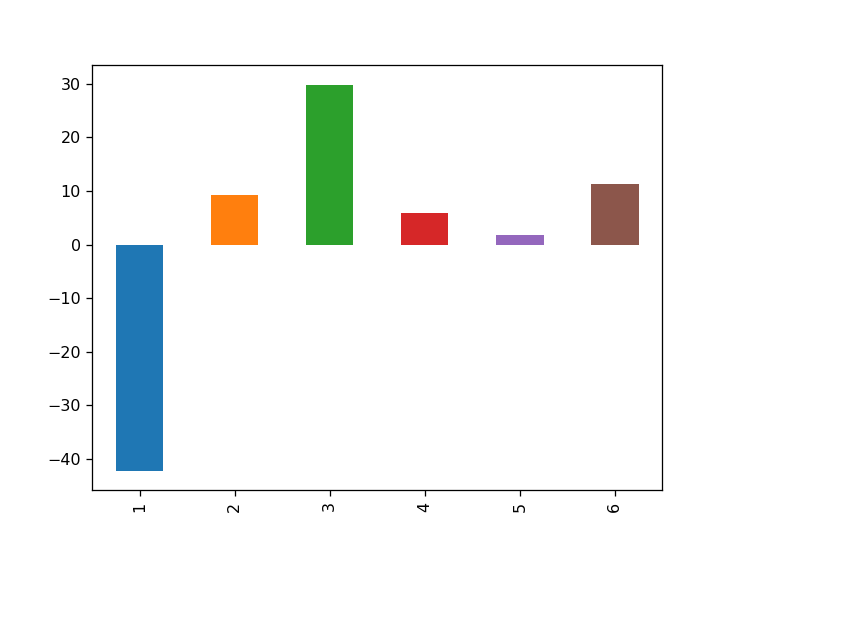

In [6]:
%matplotlib notebook
co2_emissions = sat_c.as_data_frame().loc['air/unspecified/carbon dioxide/kg', :].copy()
co2_emissions.index = [label[0] for label in co2_emissions.index]
co2_emissions.plot.bar()

## Calculating results
With our commodity by commodity direct requirements coefficients matrix, our
commodity based satellite table, and our 
[example LCIA factors](https://github.com/USEPA/IO-Model-Builder/blob/master/example/lcia_factors.csv)
we can create our environmentally extended input-output model:

In [13]:
eeio_model = iomb.make_model(
        'drc.csv', 
        ['satellite_table_com.csv'], 
        'sector_meta_data.csv',
        ia_tables=['lcia_factors.csv'])

To quickly check if everything is correct, we can use the validation function of
`iomb`:

In [14]:
import iomb.validation as validation

validation.validate(eeio_model)

The result of a model can then be calculated for a demand vector where the
demand vector is a simple dictionary with the respective sector keys and 
required amounts:

In [15]:
result = iomb.calculate(eeio_model, {'3/construction & manufacturing/us': 1})
result.lcia_total

,Total
useeio-lcia/smog/kg o3 eq,3.839711e-03
useeio-lcia/ghg/kg co2 eq,5.451214e+01
useeio-lcia/htox-nc/ctuh,3.230109e-12
useeio-lcia/htox-hc/ctuh,8.866966e-12


The result object has several fields which are again all pandas DataFrame objects.
Thus, we can for example analyze the direct global warming impact of the sectors
in our example:

<IPython.core.display.Javascript object>


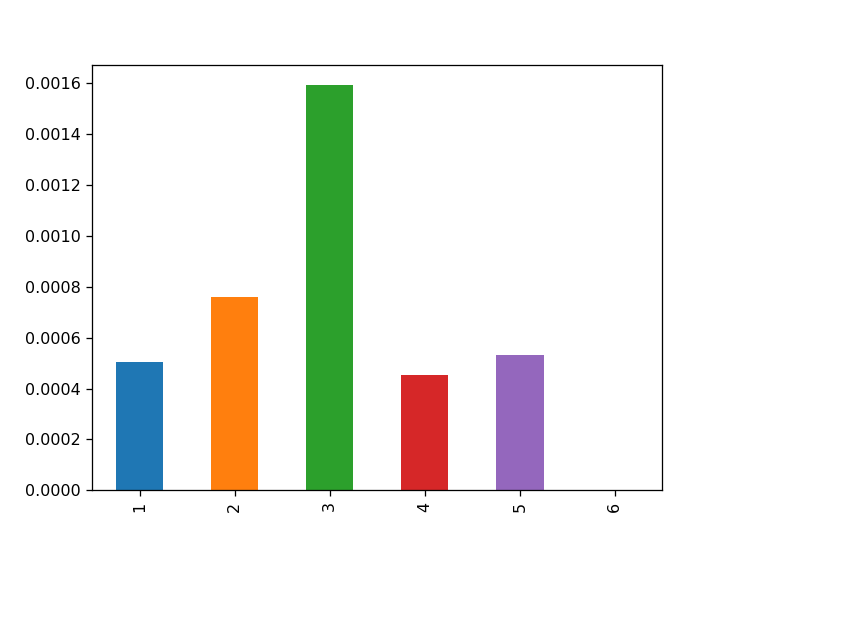

In [17]:
%matplotlib notebook
smog_contributions = result.lcia_contributions.loc['useeio-lcia/smog/kg o3 eq', :].copy()
smog_contributions.index = [label[0] for label in smog_contributions.index]
smog_contributions.plot.bar()


The calculation function accepts an additional optional parameter for the result
perspective for which the contributions should be calculated (the total results
are the same for all perspectives):

* `iomb.calc.DIRECT_PERSPECTIVE` (=`direct`): calculates the direct contributions
  of the sectors for the given demand (this is the default option)
* `iomb.calc.INTERMEDIATE_PERSPECTIVE` (=`intermediate`): calculates the upstream
  result contributions of the sectors for the given demand
* `iomb.calc.FINAL_PERSPECTIVE` (=`final`): calculates the aggregated 
  contributions of sectors in the demand


## Exporting models
A model can be exported into a JSON-LD package which can be imported
into [openLCA](http://www.openlca.org/). A model can also be exported as a series of binary and CSV files
for use in the [USEEIO API](https://github.com/USEPA/USEEIO_API/).

In [14]:
#Export model to openLCA JSON-LD format
import iomb.olca as olca
olca.Export(eeio_model).to('example_jsonld.zip')

In [19]:
#Export model as binary and csv files for use in the USEEIO API
import iomb.matio as matio
import os
model_export = matio.Export(eeio_model)
matrix_dir = './matrices'
os.mkdir(matrix_dir)
model_export.to_dir(matrix_dir,exportDQImatrices=True)

In [20]:
#Show the binary and csv files exported
os.listdir(matrix_dir)

['A.bin',
 'B.bin',
 'B_dqi.csv',
 'C.bin',
 'D.bin',
 'D_dqi.csv',
 'flows.csv',
 'indicators.csv',
 'L.bin',
 'sectors.csv',
 'U.bin',
 'U_dqi.csv']